## Simulating Data

This is notebook is for producing simulated Quasi Periodic Oscillations and fitting GPs on them

The data used to simulate the QPO lightcurves.

|Parameter      |    $K_{rn}$ values   |    $K_{qpo + rn}$ values   |
|:--------------|:--------------------:|:--------------------------:|
|$a_{rn}$       |  exp(1)              |  exp(1)                    |
|$c_{rn}$       |  exp(1) $s^{-1}$     |  exp(1) $s^{-1}$           |
|$a_{qpo}$      |      -               |  exp(-2) or exp(-0.4)      |
|$c_{qpo}$      |      -               |  exp(1) $s^{-1}$           |
|$f_{qpo}$      |      -               |      20 Hz                 |
|A              |      3               |      3                     |
|$t_{0}$        |      0.5 s           |      0.5 s                 |
|$\sigma$       |      0.2 s           |      0.2 s                 |

We will produce 1000 simulated light curves of all three of these parameters and they will be 1s long with 256 time bins. The mean model will be a skew gaussian.

In [7]:
# Loading Dependencies

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import tinygp
from tinygp import GaussianProcess
from stingray import Lightcurve
jax.config.update("jax_enable_x64", True)

In [5]:
from tinygp import kernels

def plot_kernel(kernel, **kwargs):
    dx = np.linspace(0, 5, 100)
    plt.plot(dx, kernel(dx, dx[:1]), **kwargs)
    plt.xlabel("dx")
    plt.ylabel("k(dx)")

In [30]:
# Making kernels for the lightcurves

class QPO_kernel(tinygp.kernels.Kernel):
    """
    An inheritance class for tinygp.kernels.kernels which makes a
    kernel for a QPO structure.
    This QPO covariance function is based on the Lorentzian function with
    qpo representation and an added red noise.
    Parameters
    ----------
    arn  : float
        The amplitude of the Red noise
    crn  : float
        The decay value for the red noise
    aqpo : float
        The amplitude of the lorentzian
    cqpo : float
        The decay value for the qpo frequency
    freq : float
        The modelled frequency for the QPO
    """

    def __init__(self, arn, crn, aqpo, cqpo, freq):
        self.arn = jnp.atleast_1d(arn)
        self.crn = jnp.atleast_1d(crn)
        self.aqpo = jnp.atleast_1d(aqpo)
        self.cqpo = jnp.atleast_1d(cqpo)
        self.freq = jnp.atleast_1d(freq)

    def evaluate(self, X1, X2):
        tau = jnp.atleast_1d(jnp.abs(X1 - X2))[..., None]
        return jnp.sum(
            self.aqpo
            * jnp.prod(jnp.exp(-self.cqpo * tau) * jnp.cos(2 * jnp.pi * self.freq * tau), axis=-1)
            +
            self.arn
            * jnp.prod(jnp.exp(-self.crn * tau), axis=-1)
        )

# As all models have same so put here itself
A = 3
t0 = 0.5
sig = 0.2
def skew_gaussian(t):
    return A * jnp.exp(-((t - t0)**2)/(2*(sig**2)))

def build_gp(params,t):
    kernel = QPO_kernel(
        jnp.exp(params["arn"]),
        jnp.exp(params["crn"]),
        jnp.exp(params["aqpo"]),
        jnp.exp(params["cqpo"]),
        jnp.exp(params["freq"]),
    )
    mean = skew_gaussian(t)
    return tinygp.GaussianProcess(
        kernel, t, mean=skew_gaussian
    )


In [31]:
# Making the rn kernel

rnparams = {
    "arn": jnp.exp(1.0),
    "crn": jnp.exp(1.0),
    "aqpo": 0.0,
    "cqpo": 0.0,
    "freq": 0.0,
}

rnkernel = QPO_kernel(rnparams["arn"], rnparams["crn"], 
                      rnparams["aqpo"], rnparams["cqpo"], rnparams["freq"])

def plot_kernel(kernel, **kwargs):
    dx = np.linspace(0, 1, 50)
    plt.plot(dx, kernel(dx, dx[:1]), **kwargs)
    plt.xlabel("dx")
    plt.legend()
    plt.ylabel("k(dx)")

In [32]:
lqpoparams = {
    "arn" : jnp.exp(1.0),
    "crn" : jnp.exp(1.0),
    "aqpo": jnp.exp(-2),
    "cqpo": jnp.exp(1),
    "freq": 20,
}

lqpokernel = QPO_kernel(lqpoparams["arn"], lqpoparams["crn"],
                       lqpoparams["aqpo"], lqpoparams["cqpo"], lqpoparams["freq"])


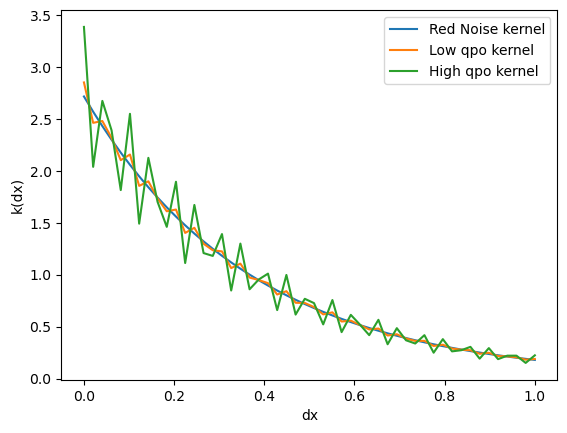

In [33]:
hqpoparams = {
    "arn" : jnp.exp(1.0),
    "crn" : jnp.exp(1.0),
    "aqpo": jnp.exp(-0.4),
    "cqpo": jnp.exp(1),
    "freq": 20,
}

hqpokernel = QPO_kernel(hqpoparams["arn"], hqpoparams["crn"],
                       hqpoparams["aqpo"], hqpoparams["cqpo"], hqpoparams["freq"])

plot_kernel(rnkernel, label="Red Noise kernel")
plot_kernel(lqpokernel, label="Low qpo kernel")
plot_kernel(hqpokernel, label="High qpo kernel")

Text(0, 0.5, 'M(x)')

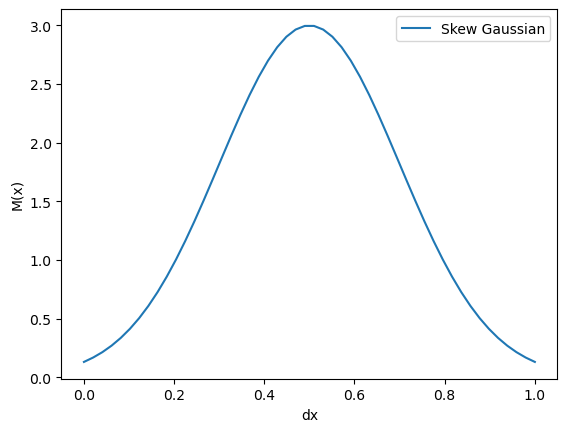

In [34]:
# Plotting the mean function:-
dx = np.linspace(0, 1, 50)
plt.plot(dx, skew_gaussian(dx), label = "Skew Gaussian")
plt.xlabel("dx")
plt.legend()
plt.ylabel("M(x)")

Text(0.5, 0, 'x')

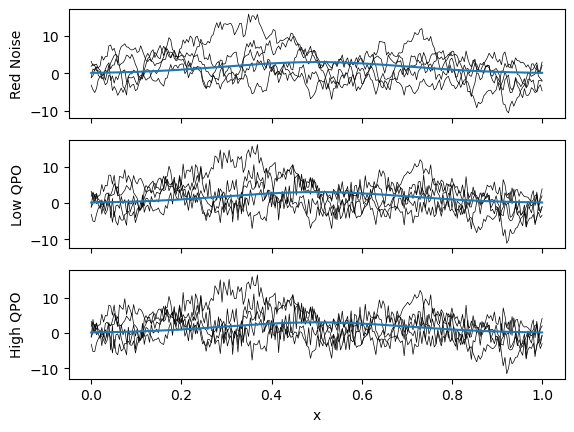

In [40]:
# Making the simulated data
times = np.linspace(0, 1, 256)
rngp = build_gp(rnparams, times)
lqpop = build_gp(lqpoparams, times)
hqpop = build_gp(hqpoparams, times)

rngp_sample = rngp.sample(jax.random.PRNGKey(4), shape=(5,))
lqpogp_sample = lqpop.sample(jax.random.PRNGKey(4), shape=(5,))
hqpogp_sample = hqpop.sample(jax.random.PRNGKey(4), shape=(5,))

# Plotting these samples
_, axes = plt.subplots(3, 1, sharex=True)
ax = axes[0]
ax.plot(times, rngp_sample.T, color="k", lw=0.5)
ax.plot(times, jax.vmap(skew_gaussian)(times), label="mean")
ax.set_ylabel("Red Noise")

ax = axes[1]
ax.plot(times, lqpogp_sample.T, color="k", lw=0.5)
ax.plot(times, jax.vmap(skew_gaussian)(times), label="mean")
ax.set_ylabel("Low QPO")

ax = axes[2]
ax.plot(times, hqpogp_sample.T, color="k", lw=0.5)
ax.plot(times, jax.vmap(skew_gaussian)(times), label="mean")
ax.set_ylabel("High QPO")

ax.set_xlabel("x")

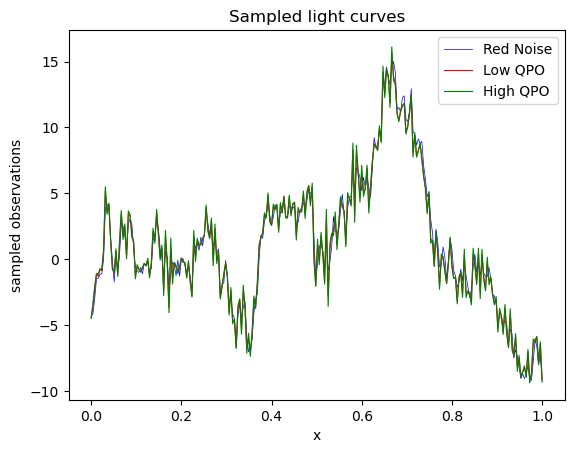

In [52]:
rngp_sample2   =  rngp.sample(jax.random.PRNGKey(4), shape=(1,))
lqpogp_sample2 = lqpop.sample(jax.random.PRNGKey(4), shape=(1,))
hqpogp_sample2 = hqpop.sample(jax.random.PRNGKey(4), shape=(1,))

plt.plot(times, rngp_sample2.T, lw=0.5,color = "b" ,label = "Red Noise")
plt.plot(times, lqpogp_sample2.T, lw=0.8, color = "r", label = "Low QPO")
plt.plot(times, hqpogp_sample2.T, lw=0.8, color = "g", label = "High QPO")
plt.xlabel("x")
plt.ylabel("sampled observations")
plt.legend()
_ = plt.title("Sampled light curves")

# Why so similar, what about -ve elements?